In [190]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import pandapower as pp # type: ignore
import matplotlib.pyplot as plt # type: ignore 
import pandapower.plotting as plot


In [191]:
#Sistema varias barras
net = pp.create_empty_network()

barra1 = pp.create_bus(net, vn_kv=110, name="Barra 1")
barra2 = pp.create_bus(net, vn_kv=220, name="Barra 2")
barra1A = pp.create_bus(net, vn_kv=220, name="Barra 1A")
barra1B = pp.create_bus(net, vn_kv=220, name="Barra 1B")
barra2A = pp.create_bus(net, vn_kv=220, name="Barra 2A")
barra2B = pp.create_bus(net, vn_kv=220, name="Barra 2B")
barra3A = pp.create_bus(net, vn_kv=220, name="Barra 3A")

pp.create_transformer(net, barra2, barra1, std_type="100 MVA 220/110 kV")

pp.create_ext_grid(net, barra1, vm_pu=1.0, name="Slack bus")

pp.create_load(net, barra1A, p_mw=30, q_mvar=20, name="Carga 1A")
pp.create_load(net, barra1B, p_mw=15, q_mvar=10, name="Carga 1B")
pp.create_load(net, barra2A, p_mw=52.5, q_mvar=35, name="Carga 2A")
pp.create_load(net, barra2B, p_mw=90, q_mvar=60, name="Carga 2B")
pp.create_load(net, barra3A, p_mw=22.5, q_mvar=15, name="Carga 3A")


pp.create_line(net, barra2, barra1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L2-1A")
pp.create_line(net, barra1A, barra2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L1A-2A")
pp.create_line(net, barra2A, barra3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L2A-3A")
pp.create_line(net, barra3A, barra2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L3A-2B")
pp.create_line(net, barra2B, barra1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L2B-1B")
pp.create_line(net, barra1B, barra2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L1B-2")

5

In [192]:
pp.runpp(net, algorithm='nr', numba=False,max_iteration=100)

In [193]:
net.res_line.index = net.line.name
net.res_bus.index = net.bus.name

In [194]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
name,,,,
Barra 1,1.000000,0.000000,-212.310191,5.807279
Barra 2,1.033380,-14.276471,0.000000,0.000000
Barra 1A,1.031457,-14.492303,30.000000,20.000000
Barra 1B,1.032375,-14.469768,15.000000,10.000000
Barra 2A,1.029237,-14.730336,52.500000,35.000000
Barra 2B,1.027435,-14.873522,90.000000,60.000000
Barra 3A,1.028365,-14.864945,22.500000,15.000000


In [185]:
#sistema 2 barras

red = pp.create_empty_network()

bar1 = pp.create_bus(red, vn_kv=500, name="Barra 1")
bar2 = pp.create_bus(red, vn_kv=500, name="Barra 2")

pp.create_ext_grid(red, bar1, vm_pu=1.0, name="Generador")

pp.create_line_from_parameters(red, bar1, bar2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)
pp.create_line_from_parameters(red, bar1, bar2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)

pp.create_load(red, bar2, p_mw=1080.02, q_mvar=523.03, name="Carga")

pp.runpp(red, algorithm='nr', numba=False,max_iteration=100)

In [186]:
red.res_line.index = red.line.name
red.res_bus.index = red.bus.name

red.res_bus

,vm_pu,va_degree,p_mw,q_mvar
name,,,,
Barra 1,1.000000,0.000000,-1104.545327,829.086846
Barra 2,0.995341,-7.423674,1080.020000,523.030000


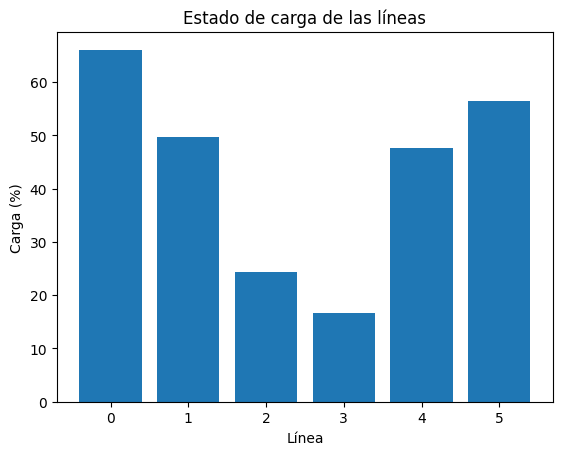

In [202]:
# Verificar si alguna tensión está fuera del rango permitido
tensiones_fuera_de_rango = net.res_bus[(net.res_bus.vm_pu < 0.93) | (net.res_bus.vm_pu > 1.07)]

# Verificar si alguna línea está saturada
lineas_saturadas = net.res_line[net.res_line.loading_percent > 100]

# Crear un gráfico que indique el estado de cada línea
plt.bar(net.line.index, net.res_line.loading_percent)
plt.xlabel('Línea')
plt.ylabel('Carga (%)')
plt.title('Estado de carga de las líneas')
plt.show()


In [203]:
# Verificar si las tensiones están fuera de norma en los dos escenarios
def verificar_tensiones_fuera_de_norma(net, escenario):
    if escenario == "normal":
        min_pu = 0.93
        max_pu = 1.07
    elif escenario == "alerta":
        min_pu = 0.9
        max_pu = 1.1
    else:
        raise ValueError("Escenario no válido. Debe ser 'normal' o 'alerta'.")

    tensiones_fuera_de_norma = net.res_bus[(net.res_bus.vm_pu < min_pu) | (net.res_bus.vm_pu > max_pu)]

    if not tensiones_fuera_de_norma.empty:
        print(f"Tensiones fuera de norma en el escenario '{escenario}':")
        print(tensiones_fuera_de_norma)
    else:
        print(f"Todas las tensiones están dentro de norma en el escenario '{escenario}'.")

# Escenario 1: Estado normal (0.93 - 1.07 pu)
verificar_tensiones_fuera_de_norma(net, "normal")

# Escenario 2: Estado de alerta (0.9 - 1.1 pu)
verificar_tensiones_fuera_de_norma(net, "alerta")


Todas las tensiones están dentro de norma en el escenario 'normal'.
Todas las tensiones están dentro de norma en el escenario 'alerta'.


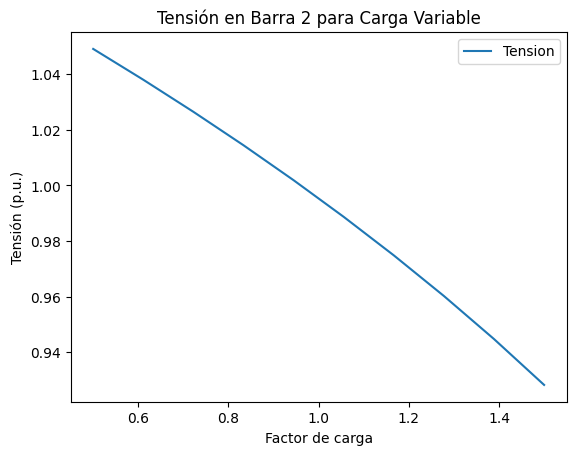

In [187]:

# Definir rango de factores de carga (±50%)
load_factors = np.linspace(0.5, 1.5, 10)

# Lista para almacenar resultados de tensión en la barra 2
voltages_bar2 = []

# Guardar el valor inicial de la carga en la barra 2
initial_p_mw = red.load.loc[red.load.name == 'Carga', 'p_mw'].values[0]
initial_q_mvar = red.load.loc[red.load.name == 'Carga', 'q_mvar'].values[0]

# Función para ajustar la carga en la barra 2
def adjust_load(factor):
    red.load.loc[red.load.name == 'Carga', 'p_mw'] = initial_p_mw * factor
    red.load.loc[red.load.name == 'Carga', 'q_mvar'] = initial_q_mvar * factor

# Simular para diferentes factores de carga
for factor in load_factors:
    adjust_load(factor)
    pp.runpp(red, numba=False)
    # Guardar tensión en la barra 2
    voltages_bar2.append(red.res_bus.loc[red.res_bus.index == bar2, 'vm_pu'].values[0])

# Convertir resultados a DataFrame para graficar
voltage_df = pd.DataFrame(voltages_bar2, columns=['Tension'], index=load_factors)

# Graficar resultados
voltage_df.plot()
plt.xlabel('Factor de carga')
plt.ylabel('Tensión (p.u.)')
plt.title('Tensión en Barra 2 para Carga Variable')
plt.show()


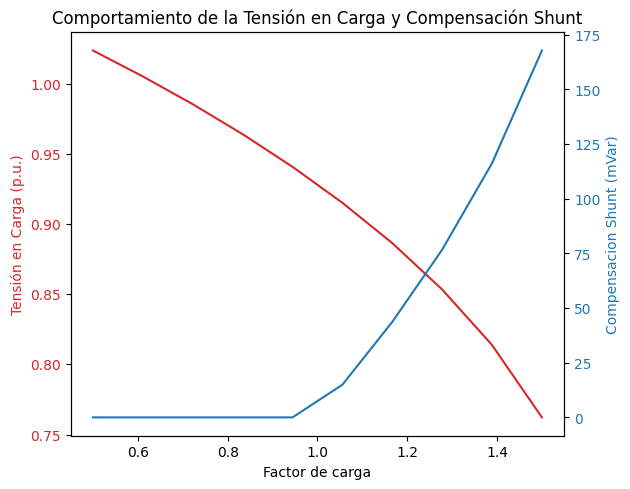

In [188]:

# Definir rango de factores de carga (±50%)
load_factors = np.linspace(0.5, 1.5, 10)

# Listas para almacenar resultados de tensión en la barra 2 y en la carga
voltages_bar2 = []
voltages_carga = []

# Guardar el valor inicial de la carga en la barra 2
initial_p_mw = red.load.loc[red.load.name == 'Carga', 'p_mw'].values[0]
initial_q_mvar = red.load.loc[red.load.name == 'Carga', 'q_mvar'].values[0]

# Función para ajustar la carga en la barra 2
def adjust_load(factor):
    red.load.loc[red.load.name == 'Carga', 'p_mw'] = initial_p_mw * factor
    red.load.loc[red.load.name == 'Carga', 'q_mvar'] = initial_q_mvar * factor

# Simular para diferentes factores de carga
for factor in load_factors:
    adjust_load(factor)
    pp.runpp(red, numba=False)
    # Guardar tensión en la barra 2
    voltages_bar2.append(red.res_bus.loc[red.res_bus.index == bar2, 'vm_pu'].values[0])
    # Guardar tensión en la carga
    voltage_carga = red.res_bus.loc[red.res_bus.index == red.load.loc[red.load.name == 'Carga', 'bus'].values[0], 'vm_pu'].values[0]
    voltages_carga.append(voltage_carga)

# Calcular compensación shunt necesaria
compensacion_shunt = []
for voltage in voltages_carga:
    if voltage < 0.93:
        compensacion_shunt.append((0.93 - voltage) * 1e3)  # Convertir a mVar
    elif voltage > 1.07:
        compensacion_shunt.append((1.07 - voltage) * 1e3)  # Convertir a mVar
    else:
        compensacion_shunt.append(0)


# Aplicar compensación shunt en la carga
for idx, compensacion in enumerate(compensacion_shunt):
    if compensacion != 0:
        pp.create_shunt(red, red.load.loc[red.load.name == 'Carga', 'bus'].values[0], q_mvar=compensacion * 1e-3)

# Correr la simulación de nuevo
pp.runpp(red, algorithm='nr', numba=False, max_iteration=100)

# Convertir resultados a DataFrame para graficar
resultados_df = pd.DataFrame({'Factor de carga': load_factors, 'Tension en Barra 2': voltages_bar2, 'Tension en Carga': voltages_carga, 'Compensacion Shunt (mVar)': compensacion_shunt})

# Graficar resultados
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Factor de carga')
ax1.set_ylabel('Tensión en Carga (p.u.)', color=color)
ax1.plot(resultados_df['Factor de carga'], resultados_df['Tension en Carga'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Compensacion Shunt (mVar)', color=color)
ax2.plot(resultados_df['Factor de carga'], resultados_df['Compensacion Shunt (mVar)'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Comportamiento de la Tensión en Carga y Compensación Shunt')
plt.show()


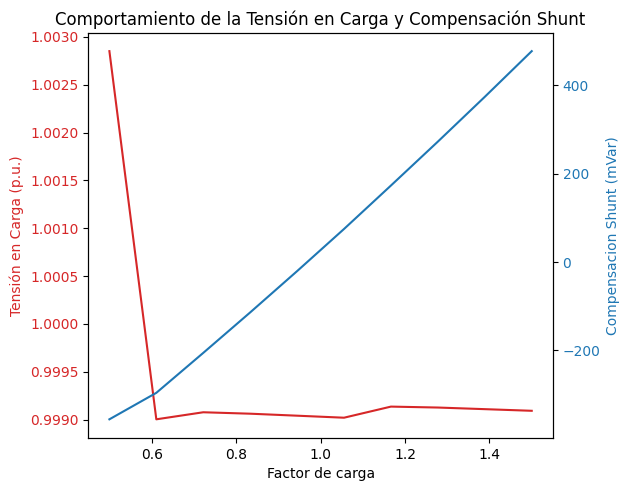

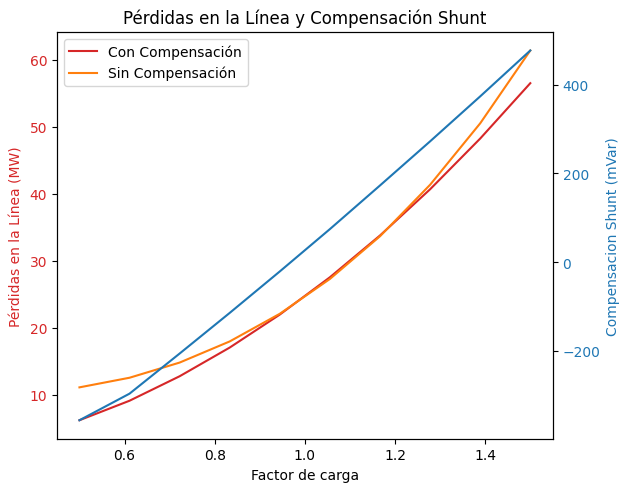

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandapower as pp

# Crear la red eléctrica
red = pp.create_empty_network()

bar1 = pp.create_bus(red, vn_kv=500, name="Barra 1")
bar2 = pp.create_bus(red, vn_kv=500, name="Barra 2")

pp.create_ext_grid(red, bar1, vm_pu=1.0, name="Generador")

pp.create_line_from_parameters(red, bar1, bar2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)
pp.create_line_from_parameters(red, bar1, bar2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)

pp.create_load(red, bar2, p_mw=1080, q_mvar=523, name="Carga")

pp.runpp(red, algorithm='nr', numba=False, max_iteration=100)


# Definir rango de factores de carga (±50%)
load_factors = np.linspace(0.5, 1.5, 10)

# Listas para almacenar resultados de tensión en la carga, compensación shunt y pérdidas
voltages_carga = []
compensacion_shunt = []
losses_with_compensation = []
losses_without_compensation = []

# Guardar el valor inicial de la carga en la barra 2
initial_p_mw = red.load.loc[red.load.name == 'Carga', 'p_mw'].values[0]
initial_q_mvar = red.load.loc[red.load.name == 'Carga', 'q_mvar'].values[0]

# Función para ajustar la carga en la barra 2
def adjust_load(factor):
    red.load.loc[red.load.name == 'Carga', 'p_mw'] = initial_p_mw * factor
    red.load.loc[red.load.name == 'Carga', 'q_mvar'] = initial_q_mvar * factor

# Función para ajustar la compensación shunt
def adjust_shunt_compensation(bus, target_voltage=1.0, tol=1e-3, max_iter=20):
    for _ in range(max_iter):
        pp.runpp(red, numba=False)
        voltage = red.res_bus.loc[bus, 'vm_pu']
        if np.abs(voltage - target_voltage) < tol:
            break
        # Añadir o ajustar la compensación shunt
        q_shunt = (target_voltage - voltage) * 1e3  # Compensación en mVar
        if 'Shunt' in red.sgen.name.values:
            red.sgen.loc[red.sgen.name == 'Shunt', 'q_mvar'] += q_shunt
        else:
            pp.create_sgen(red, bus, p_mw=0, q_mvar=q_shunt, name='Shunt')

# Simular para diferentes factores de carga con compensación shunt
for factor in load_factors:
    adjust_load(factor)
    adjust_shunt_compensation(bar2, target_voltage=1.0, tol=1e-3, max_iter=20)
    pp.runpp(red, numba=False)
    # Guardar tensión en la carga
    voltage_carga = red.res_bus.loc[red.load.loc[red.load.name == 'Carga', 'bus'].values[0], 'vm_pu']
    # Ajustar la tensión para estar dentro del rango de 0.97 y 1.03 pu
    if voltage_carga < 0.97:
        adjust_shunt_compensation(bar2, target_voltage=0.97, tol=1e-3, max_iter=20)
    elif voltage_carga > 1.03:
        adjust_shunt_compensation(bar2, target_voltage=1.03, tol=1e-3, max_iter=20)
    pp.runpp(red, numba=False)
    voltage_carga = red.res_bus.loc[red.load.loc[red.load.name == 'Carga', 'bus'].values[0], 'vm_pu']
    voltages_carga.append(voltage_carga)
    # Guardar la compensación shunt aplicada
    if 'Shunt' in red.sgen.name.values:
        compensacion_shunt.append(red.sgen.loc[red.sgen.name == 'Shunt', 'q_mvar'].sum())
    else:
        compensacion_shunt.append(0)
    # Guardar las pérdidas en la línea
    losses_with_compensation.append(red.res_line.pl_mw.sum())

# Simular para diferentes factores de carga sin compensación shunt
red.sgen.drop(red.sgen.index, inplace=True)  # Eliminar cualquier shunt existente
for factor in load_factors:
    adjust_load(factor)
    pp.runpp(red, numba=False)
    # Guardar las pérdidas en la línea sin compensación
    losses_without_compensation.append(red.res_line.pl_mw.sum())

# Convertir resultados a DataFrame para graficar
resultados_df = pd.DataFrame({
    'Factor de carga': load_factors,
    'Tension en Carga': voltages_carga,
    'Compensacion Shunt (mVar)': compensacion_shunt,
    'Pérdidas con Compensación (MW)': losses_with_compensation,
    'Pérdidas sin Compensación (MW)': losses_without_compensation
})

# Graficar resultados
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Factor de carga')
ax1.set_ylabel('Tensión en Carga (p.u.)', color=color)
ax1.plot(resultados_df['Factor de carga'], resultados_df['Tension en Carga'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Compensacion Shunt (mVar)', color=color)
ax2.plot(resultados_df['Factor de carga'], resultados_df['Compensacion Shunt (mVar)'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Comportamiento de la Tensión en Carga y Compensación Shunt')
plt.show()


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Factor de carga')
ax1.set_ylabel('Pérdidas en la Línea (MW)', color=color)
ax1.plot(resultados_df['Factor de carga'], resultados_df['Pérdidas con Compensación (MW)'], label='Con Compensación', color=color)
ax1.plot(resultados_df['Factor de carga'], resultados_df['Pérdidas sin Compensación (MW)'], label='Sin Compensación', color='tab:orange')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Compensacion Shunt (mVar)', color=color)
ax2.plot(resultados_df['Factor de carga'], resultados_df['Compensacion Shunt (mVar)'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Pérdidas en la Línea y Compensación Shunt')
plt.show()
